# Import statements
Following packages are necessary:

In [4]:
import random
import utils
import os
import imageio
import json
import closs
import ccall

from simplegen import SIMPLESequence
from lastengen import LASTENSequence

import tensorflow as tf
import numpy as np
import tensorflow.keras.backend as kb
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint

from unet import UNet
from unet import preprocess_input as pre_une

from matplotlib import pyplot as plt

# Checks
The version of tensorflow as well as the GPU support are checked.

In [5]:
print(tf.__version__)
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.config.experimental.get_visible_devices('GPU')

2.1.0


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Functionality
Necessary funcionality is added here

In [6]:
def plot_cube(img, x, y, val):
    
    img[y][x] = val
    img[y][x-1] = val
    img[y][x+1] = val
    img[y-1][x] = val
    img[y-1][x-1] = val
    img[y-1][x+1] = val
    img[y+1][x] = val
    img[y+1][x-1] = val
    img[y+1][x+1] = val  

# 7.1) Supervised Euclidean for LASTEN BS=2
A U-Net is trained here to predict a displacement field and the euclidean distance is taken as error.

# Data
Import training images

In [4]:
store_path = 'experiments/7_1_euclidean'

#path_fixed = '/home/julian/Documents/Studium/MT-Masterarbeit/Data/LASTEN/fix'
#path_train = '/home/julian/Documents/Studium/MT-Masterarbeit/Data/LASTEN/train'
#path_validation = '/home/julian/Documents/Studium/MT-Masterarbeit/Data/LASTEN/validation'
#path_test = '/home/julian/Documents/Studium/MT-Masterarbeit/Data/LASTEN/test'

path_fixed = r'D:\Julian\data\LASTEN\fix'
path_train = r'D:\Julian\data\LASTEN\train'
path_validation = r'D:\Julian\data\LASTEN\validation'
path_test = r'D:\Julian\data\LASTEN\test'

width = 384
height = 384

grid_width = 18
grid_height = 18

# Seeding
Seeds are set to ensure reproducible training.

In [5]:
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

# Network
A U-Net based network is instantiated with keras to run a semantic segmentation.

In [6]:
model = UNet(filters=32, layers=4, activation='linear', classes=2, input_shape=(width, height, 2))

# Training Preparation
Prepare the settings for training the model.

In [7]:
batch_size=2

train_gen = LASTENSequence(path_train,
                           path_fixed,
                           batch_size=batch_size,
                           width=width,
                           height=height,
                           grid_width=grid_width, 
                           grid_height=grid_height,
                           preprocess_input=pre_une,
                           shuffle=True,
                           label="keypoints",
                           channel="moving+fixed")

val_gen = LASTENSequence(path_validation,
                           path_fixed,
                           batch_size=batch_size,
                           width=width,
                           height=height,
                           grid_width=grid_width, 
                           grid_height=grid_height,
                           preprocess_input=pre_une,
                           shuffle=False,
                           label="keypoints",
                           channel="moving+fixed")

logger = CSVLogger(store_path + "/log")
timelogger = ccall.TimeHistory(store_path)
checker = ModelCheckpoint(store_path + "/weights.{epoch:02d}.hdf5",
                          period=10)
callbacks = [timelogger, logger, checker]

eu_loss = closs.EuclideanLoss(batch_size=batch_size, grid_width=grid_width, grid_height=grid_height, loss_type='msed')
eu_met = closs.EuclideanLoss(batch_size=batch_size, grid_width=grid_width, grid_height=grid_height, loss_type='maed')

model.compile(optimizer='adam', loss=eu_loss, metrics=[eu_met])

# Training
Run the training.

In [8]:
model.fit(train_gen,
          epochs=100,
          callbacks=callbacks,
          validation_data=val_gen,
          validation_freq=1,
          #use_multiprocessing=True,
          workers=10,
          max_queue_size=32)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 84 steps, validate for 18 steps
Epoch 1/100


C:\Users\zilkerjn\AppData\Local\Continuum\anaconda3\envs\tf2-gpu\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\zilkerjn\AppData\Local\Continuum\anaconda3\envs\tf2-gpu\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


84/84 [==============================] - 20s 242ms/step - loss: 1061.2412 - maed: 27.4715 - val_loss: 30779.5222 - val_maed: 150.9785
Epoch 2/100
84/84 [==============================] - 9s 112ms/step - loss: 488.9210 - maed: 18.2615 - val_loss: 1813.8051 - val_maed: 36.6184
Epoch 3/100
84/84 [==============================] - 9s 105ms/step - loss: 236.1991 - maed: 12.7397 - val_loss: 1233.5372 - val_maed: 31.0701
Epoch 4/100
84/84 [==============================] - 9s 104ms/step - loss: 150.9137 - maed: 10.1497 - val_loss: 551.2334 - val_maed: 20.1208
Epoch 5/100
84/84 [==============================] - 9s 108ms/step - loss: 109.2715 - maed: 8.6788 - val_loss: 539.3839 - val_maed: 19.5074
Epoch 6/100
84/84 [==============================] - 9s 110ms/step - loss: 96.9600 - maed: 8.1972 - val_loss: 351.1313 - val_maed: 16.0755
Epoch 7/100
84/84 [==============================] - 9s 104ms/step - loss: 77.9994 - maed: 7.3526 - val_loss: 204.6458 - val_maed: 11.9884
Epoch 8/100
84/84 [====

# Evaluation
Evaluate the trained network

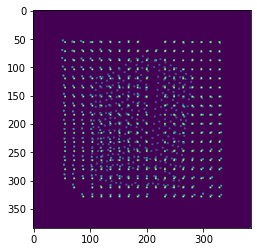

In [9]:
X, y = val_gen[0]

y_pred = model.predict(X)

u_x = y_pred[0,:,:,0]
u_y = y_pred[0,:,:,1]

plt.imshow(y_pred[0,:,:,0], cmap="gray")

plt.imsave(store_path + "/u_x.png", u_x, cmap="gray")
plt.imsave(store_path + "/u_y.png", u_y, cmap="gray")

u_x.dump(store_path + "/u_x")
u_y.dump(store_path + "/u_y")

warp = np.zeros((width, height))

for index in range(0,grid_width*grid_height):
    x_pos = int(y[0, index, 0, 0])
    y_pos = int(y[0, index, 1, 0])
    
    plot_cube(warp, x_pos, y_pos, 1) #blue
    
    ux_field = y_pred[0,:,:,0]
    uy_field = y_pred[0,:,:,1]
    
    ux = ux_field[y_pos][x_pos]
    uy = uy_field[y_pos][x_pos]
    
    x_pos = int(round(x_pos + ux))
    y_pos = int(round(y_pos + uy))
            
    plot_cube(warp, x_pos, y_pos, 2) #green    
    
    x_pos = int(y[0, index, 0, 1])
    y_pos = int(y[0, index, 1, 1])
    
    plot_cube(warp, x_pos, y_pos, 3) #yellow    
    
plt.imshow(warp)
plt.imsave(store_path + "/warp.png", warp)

# 7.2) Supervised Euclidean for LASTEN BS=4
A U-Net is trained here to predict a displacement field and the euclidean distance is taken as error.

# Data
Import training images

In [7]:
store_path = 'experiments/7_2_euclidean'

#path_fixed = '/home/julian/Documents/Studium/MT-Masterarbeit/Data/LASTEN/fix'
#path_train = '/home/julian/Documents/Studium/MT-Masterarbeit/Data/LASTEN/train'
#path_validation = '/home/julian/Documents/Studium/MT-Masterarbeit/Data/LASTEN/validation'
#path_test = '/home/julian/Documents/Studium/MT-Masterarbeit/Data/LASTEN/test'

path_fixed = r'D:\Julian\data\LASTEN\fix'
path_train = r'D:\Julian\data\LASTEN\train'
path_validation = r'D:\Julian\data\LASTEN\validation'
path_test = r'D:\Julian\data\LASTEN\test'

width = 384
height = 384

grid_width = 18
grid_height = 18

# Seeding
Seeds are set to ensure reproducible training.

In [8]:
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

# Network
A U-Net based network is instantiated with keras to run a semantic segmentation.

In [9]:
model = UNet(filters=32, layers=4, activation='linear', classes=2, input_shape=(width, height, 2))

# Training Preparation
Prepare the settings for training the model.

In [10]:
batch_size=4

train_gen = LASTENSequence(path_train,
                           path_fixed,
                           batch_size=batch_size,
                           width=width,
                           height=height,
                           grid_width=grid_width, 
                           grid_height=grid_height,
                           preprocess_input=pre_une,
                           shuffle=True,
                           label="keypoints",
                           channel="moving+fixed")

val_gen = LASTENSequence(path_validation,
                           path_fixed,
                           batch_size=batch_size,
                           width=width,
                           height=height,
                           grid_width=grid_width, 
                           grid_height=grid_height,
                           preprocess_input=pre_une,
                           shuffle=False,
                           label="keypoints",
                           channel="moving+fixed")

logger = CSVLogger(store_path + "/log")
timelogger = ccall.TimeHistory(store_path)
checker = ModelCheckpoint(store_path + "/weights.{epoch:02d}.hdf5",
                          period=10)
callbacks = [timelogger, logger, checker]

eu_loss = closs.EuclideanLoss(batch_size=batch_size, grid_width=grid_width, grid_height=grid_height, loss_type='msed')
eu_met = closs.EuclideanLoss(batch_size=batch_size, grid_width=grid_width, grid_height=grid_height, loss_type='maed')

model.compile(optimizer='adam', loss=eu_loss, metrics=[eu_met])

# Training
Run the training.

In [11]:
model.fit(train_gen,
          epochs=100,
          callbacks=callbacks,
          validation_data=val_gen,
          validation_freq=1,
          #use_multiprocessing=True,
          workers=10,
          max_queue_size=32)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 42 steps, validate for 9 steps
Epoch 1/100


C:\Users\zilkerjn\AppData\Local\Continuum\anaconda3\envs\tf2-gpu\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\zilkerjn\AppData\Local\Continuum\anaconda3\envs\tf2-gpu\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\zilkerjn\AppData\Local\Continuum\anaconda3\envs\tf2-gpu\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown s

42/42 [==============================] - 21s 509ms/step - loss: 1269.4363 - maed: 30.4606 - val_loss: 1936.4572 - val_maed: 39.5235
Epoch 2/100
42/42 [==============================] - 9s 216ms/step - loss: 426.5323 - maed: 17.1862 - val_loss: 1407.9318 - val_maed: 32.6311
Epoch 3/100
42/42 [==============================] - 9s 214ms/step - loss: 289.0492 - maed: 14.0155 - val_loss: 1834.7014 - val_maed: 37.8652
Epoch 4/100
42/42 [==============================] - 9s 220ms/step - loss: 237.2290 - maed: 12.7255 - val_loss: 1945.6251 - val_maed: 38.4672
Epoch 5/100
42/42 [==============================] - 9s 217ms/step - loss: 221.0724 - maed: 12.0144 - val_loss: 6465.6337 - val_maed: 71.7215
Epoch 6/100
42/42 [==============================] - 10s 227ms/step - loss: 200.8575 - maed: 11.6060 - val_loss: 784.3558 - val_maed: 23.1540
Epoch 7/100
42/42 [==============================] - 9s 218ms/step - loss: 103.9611 - maed: 8.4515 - val_loss: 369.5449 - val_maed: 15.2682
Epoch 8/100
42/42 

42/42 [==============================] - 10s 236ms/step - loss: 4.0821 - maed: 1.6986 - val_loss: 15.6904 - val_maed: 3.4609
Epoch 61/100
42/42 [==============================] - 10s 242ms/step - loss: 5.5860 - maed: 1.9859 - val_loss: 9.2193 - val_maed: 2.6045
Epoch 62/100
42/42 [==============================] - 10s 244ms/step - loss: 6.1591 - maed: 2.0660 - val_loss: 26.7495 - val_maed: 4.5144
Epoch 63/100
42/42 [==============================] - 10s 248ms/step - loss: 6.5688 - maed: 2.1636 - val_loss: 20.2836 - val_maed: 3.8806
Epoch 64/100
42/42 [==============================] - 10s 243ms/step - loss: 5.1352 - maed: 1.9056 - val_loss: 13.2857 - val_maed: 3.1221
Epoch 65/100
42/42 [==============================] - 10s 248ms/step - loss: 8.5128 - maed: 2.4462 - val_loss: 22.3539 - val_maed: 3.7994
Epoch 66/100
42/42 [==============================] - 10s 243ms/step - loss: 7.1601 - maed: 2.2171 - val_loss: 10.2954 - val_maed: 2.7154
Epoch 67/100
42/42 [============================

# Evaluation
Evaluate the trained network

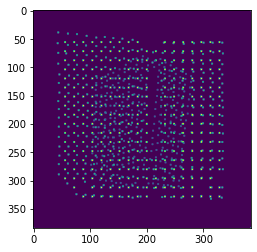

In [12]:
X, y = val_gen[0]

y_pred = model.predict(X)

u_x = y_pred[0,:,:,0]
u_y = y_pred[0,:,:,1]

plt.imshow(y_pred[0,:,:,0], cmap="gray")

plt.imsave(store_path + "/u_x.png", u_x, cmap="gray")
plt.imsave(store_path + "/u_y.png", u_y, cmap="gray")

u_x.dump(store_path + "/u_x")
u_y.dump(store_path + "/u_y")

warp = np.zeros((width, height))

for index in range(0,grid_width*grid_height):
    x_pos = int(y[0, index, 0, 0])
    y_pos = int(y[0, index, 1, 0])
    
    plot_cube(warp, x_pos, y_pos, 1) #blue
    
    ux_field = y_pred[0,:,:,0]
    uy_field = y_pred[0,:,:,1]
    
    ux = ux_field[y_pos][x_pos]
    uy = uy_field[y_pos][x_pos]
    
    x_pos = int(round(x_pos + ux))
    y_pos = int(round(y_pos + uy))
            
    plot_cube(warp, x_pos, y_pos, 2) #green    
    
    x_pos = int(y[0, index, 0, 1])
    y_pos = int(y[0, index, 1, 1])
    
    plot_cube(warp, x_pos, y_pos, 3) #yellow    
    
plt.imshow(warp)
plt.imsave(store_path + "/warp.png", warp)

# 7.3) Supervised Euclidean for LASTENS BS=4
A U-Net is trained here to predict a displacement field and the euclidean distance is taken as error.

# Data
Import training images

In [13]:
store_path = 'experiments/7_3_euclidean'

#path_fixed = '/home/julian/Documents/Studium/MT-Masterarbeit/Data/LASTENS/fix'
#path_train = '/home/julian/Documents/Studium/MT-Masterarbeit/Data/LASTENS/train'
#path_validation = '/home/julian/Documents/Studium/MT-Masterarbeit/Data/LASTENS/validation'
#path_validation_2 = '/home/julian/Documents/Studium/MT-Masterarbeit/Data/LASTEN/validation'
#path_test = '/home/julian/Documents/Studium/MT-Masterarbeit/Data/LASTENS/test'

path_fixed = r'D:\Julian\data\LASTENS\fix'
path_train = r'D:\Julian\data\LASTENS\train'
path_validation = r'D:\Julian\data\LASTENS\validation'
path_validation_2 = r'D:\Julian\data\LASTEN\validation'
path_test = r'D:\Julian\data\LASTENS\test'

width = 384
height = 384

grid_width = 18
grid_height = 18

# Seeding
Seeds are set to ensure reproducible training.

In [14]:
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

# Network
A U-Net based network is instantiated with keras to run a semantic segmentation.

In [15]:
model = UNet(filters=32, layers=4, activation='linear', classes=2, input_shape=(width, height, 2))

# Training Preparation
Prepare the settings for training the model.

In [16]:
batch_size=4

train_gen = LASTENSequence(path_train,
                           path_fixed,
                           batch_size=batch_size,
                           width=width,
                           height=height,
                           grid_width=grid_width, 
                           grid_height=grid_height,
                           preprocess_input=pre_une,
                           shuffle=True,
                           label="keypoints",
                           channel="moving+fixed")

val_gen = LASTENSequence(path_validation,
                           path_fixed,
                           batch_size=batch_size,
                           width=width,
                           height=height,
                           grid_width=grid_width, 
                           grid_height=grid_height,
                           preprocess_input=pre_une,
                           shuffle=False,
                           label="keypoints",
                           channel="moving+fixed")

val_gen_2 = LASTENSequence(path_validation_2,
                           path_fixed,
                           batch_size=batch_size,
                           width=width,
                           height=height,
                           grid_width=grid_width, 
                           grid_height=grid_height,
                           preprocess_input=pre_une,
                           shuffle=False,
                           label="keypoints",
                           channel="moving+fixed")

timelogger = ccall.TimeHistory(store_path)
vallogger = ccall.ValidationHistory(store_path, val_gen_2)
logger = CSVLogger(store_path + "/log")
checker = ModelCheckpoint(store_path + "/weights.{epoch:02d}.hdf5",
                          period=10)
callbacks = [timelogger, logger, checker, vallogger]

eu_loss = closs.EuclideanLoss(batch_size=batch_size, grid_width=grid_width, grid_height=grid_height, loss_type='msed')
eu_met = closs.EuclideanLoss(batch_size=batch_size, grid_width=grid_width, grid_height=grid_height, loss_type='maed')

model.compile(optimizer='adam', loss=eu_loss, metrics=[eu_met])

# Training
Run the training.

In [17]:
model.fit(train_gen,
          epochs=100,
          callbacks=callbacks,
          validation_data=val_gen,
          validation_freq=1,
          #use_multiprocessing=True,
          workers=10,
          max_queue_size=32)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 840 steps, validate for 180 steps
Epoch 1/100


C:\Users\zilkerjn\AppData\Local\Continuum\anaconda3\envs\tf2-gpu\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\zilkerjn\AppData\Local\Continuum\anaconda3\envs\tf2-gpu\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\zilkerjn\AppData\Local\Continuum\anaconda3\envs\tf2-gpu\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown s

839/840 [============================>.] - ETA: 0s - loss: 1008.0742 - maed: 24.4702WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
840/840 [==============================] - 150s 179ms/step - loss: 1007.3305 - maed: 24.4594 - val_loss: 675.7757 - val_maed: 20.9108
Epoch 2/100
839/840 [============================>.] - ETA: 0s - loss: 355.6490 - maed: 14.8403WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
840/840 [==============================] - 131s 156ms/step - loss: 355.8691 - maed: 14.8430 - val_loss: 365.7270 - val_maed: 15.1534
Epoch 3/100
839/840 [============================>.] - ETA: 0s - loss: 258.0015 - maed: 12.5373WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
840/840 [==============================] - 132s 157ms/step - loss: 257.8283 - maed: 12.5321 - val_loss: 241.4741 - val_maed: 12.1230
Epoch 4/100
839/840 [============================>.] - ETA: 0s - loss: 201.7587 

840/840 [==============================] - 128s 152ms/step - loss: 27.7165 - maed: 4.0803 - val_loss: 58.7922 - val_maed: 5.5019
Epoch 22/100
839/840 [============================>.] - ETA: 0s - loss: 30.6067 - maed: 4.2312WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
840/840 [==============================] - 128s 153ms/step - loss: 30.5990 - maed: 4.2311 - val_loss: 58.4055 - val_maed: 5.6185
Epoch 23/100
839/840 [============================>.] - ETA: 0s - loss: 24.7755 - maed: 3.8538WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
840/840 [==============================] - 137s 163ms/step - loss: 24.7847 - maed: 3.8546 - val_loss: 53.6673 - val_maed: 5.2552
Epoch 24/100
839/840 [============================>.] - ETA: 0s - loss: 24.2098 - maed: 3.8022WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
840/840 [==============================] - 136s 162ms/step - loss: 24.2111 - maed: 3.

Epoch 63/100
839/840 [============================>.] - ETA: 0s - loss: 5.7798 - maed: 1.7292WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
840/840 [==============================] - 141s 168ms/step - loss: 5.7800 - maed: 1.7293 - val_loss: 28.4240 - val_maed: 3.1474
Epoch 64/100
839/840 [============================>.] - ETA: 0s - loss: 5.9429 - maed: 1.7254WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
840/840 [==============================] - 137s 163ms/step - loss: 5.9399 - maed: 1.7250 - val_loss: 36.9060 - val_maed: 3.7674
Epoch 65/100
839/840 [============================>.] - ETA: 0s - loss: 5.2264 - maed: 1.6284WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
840/840 [==============================] - 145s 173ms/step - loss: 5.2446 - maed: 1.6307 - val_loss: 30.3182 - val_maed: 3.1748
Epoch 66/100
839/840 [============================>.] - ETA: 0s - loss: 5.5597 - maed: 1.67

# Evaluation
Evaluate the trained network

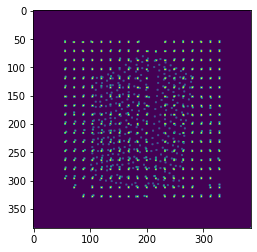

In [25]:
X, y = val_gen[0]

y_pred = model.predict(X)

u_x = y_pred[0,:,:,0]
u_y = y_pred[0,:,:,1]

plt.imshow(y_pred[0,:,:,0], cmap="gray")

plt.imsave(store_path + "/u_x.png", u_x, cmap="gray")
plt.imsave(store_path + "/u_y.png", u_y, cmap="gray")

u_x.dump(store_path + "/u_x")
u_y.dump(store_path + "/u_y")

warp = np.zeros((width, height))

for index in range(0,grid_width*grid_height):
    x_pos = int(y[0, index, 0, 0])
    y_pos = int(y[0, index, 1, 0])
    
    plot_cube(warp, x_pos, y_pos, 1) #blue
    
    ux_field = y_pred[0,:,:,0]
    uy_field = y_pred[0,:,:,1]
    
    ux = ux_field[y_pos][x_pos]
    uy = uy_field[y_pos][x_pos]
    
    x_pos = int(round(x_pos + ux))
    y_pos = int(round(y_pos + uy))
            
    plot_cube(warp, x_pos, y_pos, 2) #green    
    
    x_pos = int(y[0, index, 0, 1])
    y_pos = int(y[0, index, 1, 1])
    
    plot_cube(warp, x_pos, y_pos, 3) #yellow    
    
plt.imshow(warp)
plt.imsave(store_path + "/warp.png", warp)